# Jupyter with PostgreSQL

## Libararies and Settings

In [178]:
# Libraries
import os
import re
import psycopg2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(os.getcwd())

/


## Create database connection

In [179]:
conn = psycopg2.connect("host=localhost dbname=app user=app_user password=app_password")

## Read data

In [180]:
df = pd.read_csv('/workspace/Tutti.csv', sep=',')
df.head(5)

,web-scraper-order,web-scraper-start-url,location_date,brand_type,price
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3'900.-
1,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5'990.-
2,1703597180-3,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Thurgau, 8370, 26.06.2018, auf autoscout24.ch",LANCIA Dedra 2.0 HF Integrale,6'950.-
3,1703597180-4,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Bern, 3604, 04.06.2018, auf autoscout24.ch",LANCIA BETA 2000 Spider,19'990.-
4,1703597180-5,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Bern, 4943, 04.04.2018, auf autoscout24.ch",VW Polo 1300 C (X),12'900.-


## Count number of rows and columns in the data frame

In [181]:
# Dimension (rows, columns)
print('Dimension:', df.shape)

# Number of rows
print('Number of rows:', df.shape[0])

# Number of columns
print('Number of columns:', df.shape[1])

Dimension: (2804, 5)
Number of rows: 2804
Number of columns: 5


## Extract and save relevant information from raw data using regular expressions (regex)

### Extract Canton

In [182]:
# Extrahiere das erste Wort vor dem Komma in den Strings der 'location_date' Spalte
cantons = []
for i in df['location_date']:
    split_string = i.split(',')[0].strip()  # Teilt den String am Komma und nimmt den ersten Teil
    cantons.append(split_string)

# Speichere als neue Variable im Pandas DataFrame
df['canton'] = cantons

# Gib die ersten 5 Werte aus
print(df['location_date'].head(5), '\n')
print(df['canton'].head(5))

0      Waadt, 1026, 03.10.2018, auf autoscout24.ch
1     Aargau, 5054, 08.09.2018, auf autoscout24.ch
2    Thurgau, 8370, 26.06.2018, auf autoscout24.ch
3       Bern, 3604, 04.06.2018, auf autoscout24.ch
4       Bern, 4943, 04.04.2018, auf autoscout24.ch
Name: location_date, dtype: object 

0      Waadt
1     Aargau
2    Thurgau
3       Bern
4       Bern
Name: canton, dtype: object


### Extract PLZ

In [183]:

# Extrahiere die PLZ, die nach dem ersten und vor dem zweiten Komma kommt
plz_list = []
for i in df['location_date']:
    parts = i.split(',')
    try:
        plz = parts[1].strip()  # Wählt den zweiten Teil nach dem Split, der die PLZ enthält
    except IndexError:
        plz = None  # Falls weniger als 2 Kommas vorhanden sind
    plz_list.append(plz)

# Speichere als neue Variable im Pandas DataFrame
df['plz'] = plz_list

df = df[df['plz'].apply(lambda x: len(str(x)) == 4)]

try:
    df['plz'] = df['plz'].astype('int64')
except ValueError:
    print("Konvertierung fehlgeschlagen: Die Spalte enthält ungültige oder fehlende Werte.")

# Gib die ersten 5 Werte aus
print(df['location_date'].head(5), '\n')
print(df['plz'].head(5))


0      Waadt, 1026, 03.10.2018, auf autoscout24.ch
1     Aargau, 5054, 08.09.2018, auf autoscout24.ch
2    Thurgau, 8370, 26.06.2018, auf autoscout24.ch
3       Bern, 3604, 04.06.2018, auf autoscout24.ch
4       Bern, 4943, 04.04.2018, auf autoscout24.ch
Name: location_date, dtype: object 

0    1026
1    5054
2    8370
3    3604
4    4943
Name: plz, dtype: int64


### Remove .- in the price and set the type to float

In [184]:
df['price'] = df['price'].str.replace("'", "")  # Entfernt Apostroph (Tausendertrennzeichen)

# Kann nur einmal ausgeführt werden, da der Typ nur einmalig geändert werden kann! Sonst benötigt es einen neuen "Alle Ausführen".
df['price'] = df['price'].replace({r'\.-$': ''}, regex=True).astype(float) 
df['price'].head()

0     3900.0
1     5990.0
2     6950.0
3    19990.0
4    12900.0
Name: price, dtype: float64

In [185]:
df.dtypes

web-scraper-order         object
web-scraper-start-url     object
location_date             object
brand_type                object
price                    float64
canton                    object
plz                        int64
dtype: object

## Count and identify missing values (if any)

In [186]:
# Count missing values
print(pd.isna(df).sum())

# Identify rows with missing values
df[df.isna().any(axis=1)].head()

web-scraper-order        0
web-scraper-start-url    0
location_date            0
brand_type               0
price                    0
canton                   0
plz                      0
dtype: int64


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz


### Count and identify dublicates

In [187]:
# Count duplicated values
print(df.duplicated().sum())

# Identify rows with duplicated values, e.g.:
df[df[['web-scraper-order', 'location_date', 'brand_type']].duplicated()]

0


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz


In [188]:
# Geocoded data (i.e. data with latitude and longitude)
df_geo = pd.read_csv('/workspace/PLZ_Ortschaft_BFSNummer.csv', 
                     sep=';', 
                     encoding='utf-8')

# Rename columns
df_geo = df_geo.rename(columns={'Gemeindename':'ort',
                                'BFS-Nr':'bfs_number', 
                                'PLZ':'plz'})

# Show data
df_geo[['ort', 
        'bfs_number', 
        'plz']].head()

,ort,bfs_number,plz
0,Aeugst am Albis,1,8914
1,Aeugst am Albis,1,8914
2,Affoltern am Albis,2,8909
3,Affoltern am Albis,2,8910
4,Bonstetten,3,8906


### Join informations

In [189]:
df2 = df.merge(df_geo[['ort',  
                       'bfs_number', 
                       'plz']], 
               on="plz")
df2.head()


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz,ort,bfs_number
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632
1,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Echandens,5633
2,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275
3,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Moosleerau,4277
4,1703597192-34,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 16.03.2020, auf autoscout24.ch",MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275


## Add municipalities

In [190]:
df_municip = pd.read_excel('/workspace/municipality_data (1).xlsx', 
                           sheet_name='data_for_import')
df_municip.head(5)

,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,1,Aeugst am Albis,1981,250.442478,14.184755,442.0,105013.570634
1,2,Affoltern am Albis,12303,1161.756374,28.700317,6920.0,71059.805603
2,3,Bonstetten,5572,749.932705,16.564968,1014.0,88927.698145
3,4,Hausen am Albis,3751,275.808824,16.022394,1021.0,86300.455137
4,5,Hedingen,3778,578.560490,16.410799,1478.0,90811.205330


In [191]:
# Merge needs a key which must be identical in both data sets (here the key is 'bfs_number')
df3 = df2.merge(df_municip[['bfs_number', 
                            'pop', 
                            'pop_dens', 
                            'frg_pct', 
                            'emp',
                            'mean_taxable_income']], 
                on="bfs_number")
df3.head(5)

,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Echandens,5633,2733,704.381443,28.357117,1538.0,110657.384760
2,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,1703597192-34,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 16.03.2020, auf autoscout24.ch",MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,1703597214-95,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 02.03.2022, auf Autoscout24.ch",ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Calculate some mean Prices for Car Types

In [192]:
# Using pivot_table to reshape the data and calculate means 
pd.pivot_table(df3[['brand_type', 'price']],
               index=['brand_type'],
               values=['price', 'brand_type'],
               aggfunc=(np.mean))

,price
brand_type,
"'53 Mercury, '60 Pontiac, '79 Chevy in blocco o singole",50000.0
"'72 Ford Ranchero 500 ""survivor""",28500.0
'91 Pontiac TransAm T.-Top option WS6 expertisée du jour,7900.0
** Ford Fiesta 1.3i / 60'000 km !!**,6900.0
** Mercedes-Benz 250 ** Veteran,19900.0
...,...
zu verkaufen,37250.0
zu verkaufen Oldtimer Triumph Spitfire IV Gabriolet,19800.0
zuverkaufen top zustand 2700 fr km 86000,2200.0


In [193]:
df4 = df3.drop(columns=['web-scraper-order', 'web-scraper-start-url', 'location_date'])
df4.head(5)

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Echandens,5633,2733,704.381443,28.357117,1538.0,110657.384760
2,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Removal of not used webscraper data

In [194]:
df4 = df3.drop(columns=['web-scraper-order','web-scraper-start-url','location_date'])

df4.head(5)

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Echandens,5633,2733,704.381443,28.357117,1538.0,110657.384760
2,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


## Write data to database

In [195]:
engine = create_engine('postgresql://app_user:app_password@db:5432/app')
df4.to_sql('car_table', engine, if_exists='replace')

820

## SQL querys

In [196]:
df_sub = pd.read_sql_query('''SELECT
                            brand_type,
                            price,
                            canton,
                            plz,
                            ort,
                            bfs_number,
                            pop,
                            pop_dens,
                            frg_pct,
                            emp,
                            mean_taxable_income
                            FROM car_table''', 
                            con=engine)
df_sub.head()

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Echandens,5633,2733,704.381443,28.357117,1538.0,110657.384760
2,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Count amount of entries per canton with a salary over 75'000

In [197]:
df_count = pd.read_sql_query('''SELECT canton, COUNT(*) AS GesamtEintraege
                            FROM car_table
                            WHERE mean_taxable_income > 75000
                            GROUP BY canton
                            ORDER BY GesamtEintraege DESC;''',
                            con=engine)
df_count.head()

,canton,gesamteintraege
0,Zürich,427
1,Zug,206
2,Tessin,182
3,Genf,117
4,Basel-Landschaft,82


In [198]:
df_avg_price = pd.read_sql_query('''SELECT brand_type, ROUND(CAST(AVG(price) AS numeric), 2) AS average_price
                                FROM car_table
                                GROUP BY brand_type;
                                ;''',
                                con=engine)

df_avg_price.head()


,brand_type,average_price
0,Ford USA Mustang V8 351 Cabriolet,17500.00
1,Jaguar XJ 3.4 Jg. 1976 grün - Oldtimer,8500.00
2,TOYOTA Celica 2000 GTi,7566.67
3,1988 BMW e30 320i,13000.00
4,Buick Skylark Veteran,5500.00


### Reshapping data 

In [199]:
df_shaped = df_sub[['ort', 'brand_type', 'price', 'canton']][:5]
print('Original shape')
print(df_shaped, '\n')

df_shaped_stacked = df_shaped.stack()
print('Stacked')
print(df_shaped_stacked, '\n')

# Using unstack
print('Unstacked (= back to original shape)')
print(df_shaped_stacked.unstack())

Original shape
           ort                  brand_type   price  canton
0       Denges    LANCIA Dedra 2.0 i.e. LX  3900.0   Waadt
1    Echandens    LANCIA Dedra 2.0 i.e. LX  3900.0   Waadt
2  Kirchleerau    VW Golf 1800 S-Plus (GL)  5990.0  Aargau
3  Kirchleerau  MITSUBISHI Colt 1400 GLX A  5990.0  Aargau
4  Kirchleerau         ROVER 827 Vitesse A  6990.0  Aargau 

Stacked
0  ort                               Denges
   brand_type      LANCIA Dedra 2.0 i.e. LX
   price                             3900.0
   canton                             Waadt
1  ort                            Echandens
   brand_type      LANCIA Dedra 2.0 i.e. LX
   price                             3900.0
   canton                             Waadt
2  ort                          Kirchleerau
   brand_type      VW Golf 1800 S-Plus (GL)
   price                             5990.0
   canton                            Aargau
3  ort                          Kirchleerau
   brand_type    MITSUBISHI Colt 1400 GLX A
   pr

In [200]:
df_sub_melt = df_sub[['brand_type', 'price', 'canton']][:5]
print('Original shape')
print(df_sub_melt, '\n')

print('Reshaped using .melt()')
print(pd.melt(df, id_vars=['brand_type'], value_vars=['price', 'canton']))

Original shape
                   brand_type   price  canton
0    LANCIA Dedra 2.0 i.e. LX  3900.0   Waadt
1    LANCIA Dedra 2.0 i.e. LX  3900.0   Waadt
2    VW Golf 1800 S-Plus (GL)  5990.0  Aargau
3  MITSUBISHI Colt 1400 GLX A  5990.0  Aargau
4         ROVER 827 Vitesse A  6990.0  Aargau 

Reshaped using .melt()
                                             brand_type variable     value
0                              LANCIA Dedra 2.0 i.e. LX    price    3900.0
1                              VW Golf 1800 S-Plus (GL)    price    5990.0
2                         LANCIA Dedra 2.0 HF Integrale    price    6950.0
3                               LANCIA BETA 2000 Spider    price   19990.0
4                                    VW Polo 1300 C (X)    price   12900.0
...                                                 ...      ...       ...
5593                2CV Super mit Wohnwagen und Vorzelt   canton    Zürich
5594  Chevrolet Corvette Stingray Cabriolet Oldtimer...   canton   Thurgau
5595     

# 4 Non-graphical and graphical exploratory data analysis (EDA)

### Importing the enriched oldtimer data

In [201]:
df_orig = pd.read_sql_query('''SELECT
                            brand_type,
                            price,
                            canton,
                            plz,
                            ort,
                            bfs_number,
                            pop,
                            pop_dens,
                            frg_pct,
                            emp,
                            mean_taxable_income
                            FROM car_table''', 
                            con=engine)

# Remove duplicates
df_orig = df_orig.drop_duplicates()
df_orig.head(5)

# Remove missing values
df_orig = df_orig.dropna()
df_orig.head(5)

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Echandens,5633,2733,704.381443,28.357117,1538.0,110657.384760
2,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Quantiles original values

In [202]:
df_orig[['price', 'pop_dens']].quantile(q=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).round(2)

,price,pop_dens
0.05,1999.0,50.12
0.10,3330.0,92.74
0.25,6900.0,167.05
0.50,14900.0,417.06
0.75,24900.0,990.62
0.90,39675.0,1846.35
0.95,59425.0,2826.70
0.99,105130.0,6997.27


### Filter oldtimers

In [203]:
df_filtered = df_orig.loc[df_orig['pop_dens'] <= 5000]

df_filtered.head()

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Echandens,5633,2733,704.381443,28.357117,1538.0,110657.384760
2,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Shape (number of rows and colums)

In [204]:
print(df_filtered.shape)

(4874, 11)


### Data types

In [205]:
df_filtered.dtypes

brand_type              object
price                  float64
canton                  object
plz                      int64
ort                     object
bfs_number               int64
pop                      int64
pop_dens               float64
frg_pct                float64
emp                    float64
mean_taxable_income    float64
dtype: object

### Summary statistics of numeric variables

In [206]:
df_filtered.describe()

,price,plz,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
count,4874.000000,4874.000000,4874.000000,4874.000000,4874.000000,4874.000000,4874.000000,4874.000000
mean,19793.135618,6215.592532,2656.700041,15977.740049,730.429760,20.672290,14262.817809,73335.843417
std,22233.091771,2407.767221,1917.190041,50990.308689,883.358266,10.259145,59389.937595,21888.220973
min,100.000000,1000.000000,1.000000,53.000000,1.851209,0.000000,11.000000,33965.256410
25%,6800.000000,4410.000000,944.000000,2237.000000,165.430752,12.779221,846.000000,62860.793466
50%,14900.000000,6403.000000,2703.000000,4779.000000,403.916084,19.854987,1964.000000,68018.672199
75%,24900.000000,8500.000000,4271.000000,10990.000000,952.136864,26.996967,6048.000000,75609.385666
max,599000.000000,9657.000000,6809.000000,420217.000000,4834.831461,57.773646,491193.000000,294330.000000


### Summary statistics of numeric variables without outliers

In [207]:
# Define the criteria for filtering
min_price = 100
max_price = 125000

# Create a subset of the DataFrame without outliers
filtered_df = df_filtered.loc[
    (df_filtered['price'] >= min_price) & (df_filtered['price'] <= max_price)
]

# Display the first few rows of the filtered DataFrame
filtered_df.describe()

,price,plz,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
count,4848.000000,4848.000000,4848.000000,4848.000000,4848.000000,4848.000000,4848.000000,4848.000000
mean,18978.845503,6218.313119,2656.570338,16021.403259,728.468277,20.656595,14311.257219,73262.610385
std,18186.076302,2407.575203,1917.892804,51120.485536,882.608131,10.264874,59542.901197,21753.827611
min,100.000000,1000.000000,1.000000,53.000000,1.851209,0.000000,11.000000,33965.256410
25%,6800.000000,4410.000000,944.000000,2237.000000,165.327721,12.779221,845.000000,62860.793466
50%,14850.000000,6403.000000,2761.500000,4769.000000,402.101536,19.718462,1964.000000,68018.672199
75%,24825.000000,8500.000000,4271.000000,11004.250000,946.506550,26.992692,6048.000000,75609.385666
max,125000.000000,9657.000000,6809.000000,420217.000000,4834.831461,57.773646,491193.000000,294330.000000


### Statistical measures (min, max, std, mean, median, count) for price

In [208]:
print('Price:',
      'Count:', round(df_filtered.price.count(), 1),
      'Min:', round(df_filtered.price.min(), 1),
      'Max:', round(df_filtered.price.max(), 1),
      'Mean:', round(df_filtered.price.mean(), 1),
      'Median:', round(df_filtered.price.median(), 1),
      'Std:', round(df_filtered.price.std(), 1))

Price: Count: 4874 Min: 100.0 Max: 599000.0 Mean: 19793.1 Median: 14900.0 Std: 22233.1


### Skewness

In [209]:
df_filtered['price'].skew()

6.079525608944898

### Kurtosis

In [210]:
df_filtered['price'].kurtosis()

104.33204385466655

### Extreme values

In [211]:
# Low costs oldtimers
df_filtered[df_filtered['price'] <= 200]

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
2371,"VOLVO 850 (1st Gen.) SCHLACHTFEST, TEILE, PEZZI",100.0,Tessin,6516,Locarno,5113,15776,844.087747,34.248225,13188.0,58270.380018
3965,De Tomaso Mangusta,150.0,Zürich,8803,Kilchberg (ZH),135,8923,3458.527132,32.858904,4127.0,166467.202970
3966,Ferrari 512 S,150.0,Zürich,8803,Kilchberg (ZH),135,8923,3458.527132,32.858904,4127.0,166467.202970
3971,De Tomaso Mangusta,150.0,Zürich,8803,Rüschlikon,139,6092,2079.180887,33.650689,3050.0,162801.336616
3972,Ferrari 512 S,150.0,Zürich,8803,Rüschlikon,139,6092,2079.180887,33.650689,3050.0,162801.336616
5042,"VOLVO 850 (1st Gen.) SCHLACHTFEST, TEILE, PEZZI",100.0,Tessin,6516,Cugnasco-Gerra,5138,2845,79.424902,13.708260,400.0,66748.576214


In [212]:
# Very expensive oldtimers
df_filtered[df_filtered['price'] >= 150000]

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
835,Lancia Aurelia B20 GT,175000.0,Graubünden,7000,Chur,3901,37082,683.665192,20.298258,33020.0,70203.129376
859,Lancia Aurelia B20 GT,175000.0,Graubünden,7000,Churwalden,3911,1912,39.398310,18.828452,1050.0,54595.513460
1102,VW BUGGY MIRAGE,173000.0,Tessin,6855,Mendrisio,5254,14870,468.051621,21.983860,16431.0,74017.826637
1505,PORSCHE 911 930 3.3 Turbo,178000.0,Zürich,8800,Thalwil,141,18139,3298.000000,29.031369,6582.0,106812.909133
1800,Original Shelby GT500,150000.0,Freiburg,3215,Murten,2275,8259,334.372470,20.038746,4738.0,72068.317853
2916,350 GT,599000.0,Waadt,1580,Avenches,5451,4295,220.595788,36.600698,2641.0,59178.897209
2919,"DB 6 Mk.II, RHD, Auto.",225000.0,Waadt,1580,Avenches,5451,4295,220.595788,36.600698,2641.0,59178.897209
3817,VW BUGGY MIRAGE,173000.0,Tessin,6855,Stabio,5266,4510,733.333333,23.037694,6193.0,67048.686515
3860,OLDTIMER Alfa romeo 2600 turing,160000.0,Tessin,6982,Agno,5141,4403,1761.200000,32.932092,2772.0,71290.401302
4402,CHEVROLET Impala V8 Sport Coupé Ab Veteran MFK...,166000.0,Aargau,5436,Würenlos,4048,6494,719.955654,18.247613,2254.0,87427.654947


### Get a list of categories of categorical variable

In [213]:
np.array(pd.Categorical(df_filtered['ort']).categories)

array(['Aadorf', 'Aarau', 'Aarberg', ..., 'Zwingen', 'Zäziwil', 'Zürich'],
      dtype=object)

## Multivariate non-graphical exploratory data analysis (EDA)

### Correlation matrix

In [214]:
corr = df_filtered[['price', 'pop_dens', 'frg_pct']].cov().corr()
corr

,price,pop_dens,frg_pct
price,1.000000,0.136250,0.470137
pop_dens,0.136250,1.000000,0.938419
frg_pct,0.470137,0.938419,1.000000


### Covariance matrix

In [215]:
cov = df_filtered[['price', 'pop_dens', 'frg_pct']].cov()
cov

,price,pop_dens,frg_pct
price,4.943104e+08,484546.790669,5094.562705
pop_dens,4.845468e+05,780321.826819,5300.406102
frg_pct,5.094563e+03,5300.406102,105.250062


## Univariate graphical exploratory data analysis (EDA)

### Boxplot (seaborn)

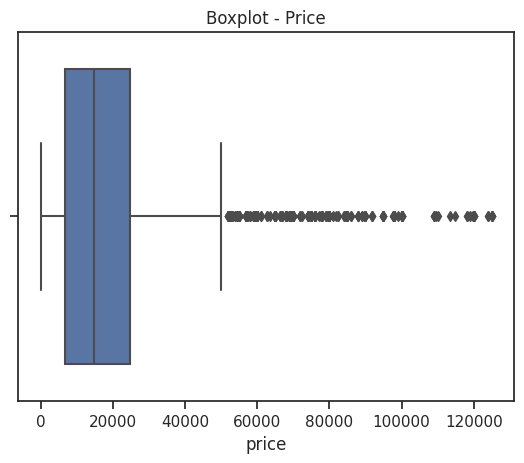

In [216]:
import seaborn as sns

sns.boxplot(x=filtered_df['price'])
plt.title('Boxplot - Price')
plt.show()

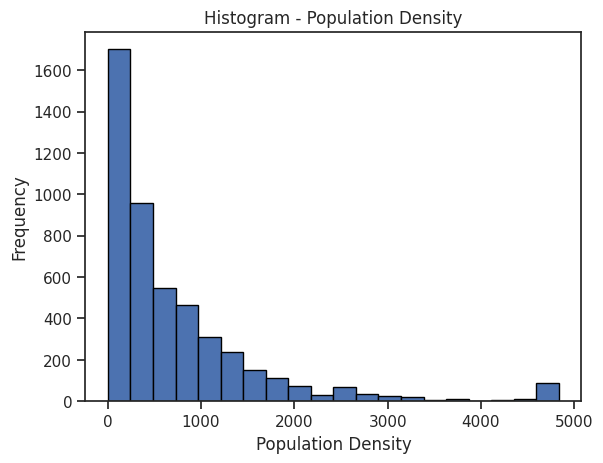

In [217]:
plt.hist(filtered_df['pop_dens'], bins=20, edgecolor='black')
plt.title('Histogram - Population Density')
plt.xlabel('Population Density')
plt.ylabel('Frequency')
plt.show()

### Density plot  (seaborn)

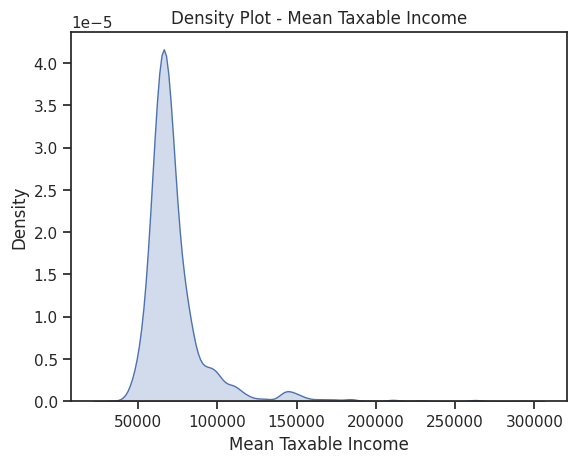

In [218]:
sns.kdeplot(filtered_df['mean_taxable_income'], fill=True)
plt.title('Density Plot - Mean Taxable Income')
plt.xlabel('Mean Taxable Income')
plt.ylabel('Density')
plt.show()

### Quantile-Quantile (QQ-) plot

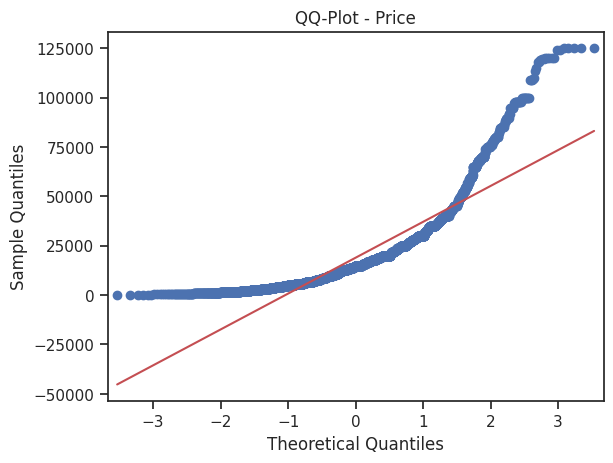

In [219]:
import statsmodels.api as sm

# Beispiel für einen QQ-Plot für die 'price'-Spalte
sm.qqplot(filtered_df['price'], line='s')
plt.title('QQ-Plot - Price')
plt.show()

## Multivariate graphical exploratory data analysis (EDA)

### Scatter plot popdens_price

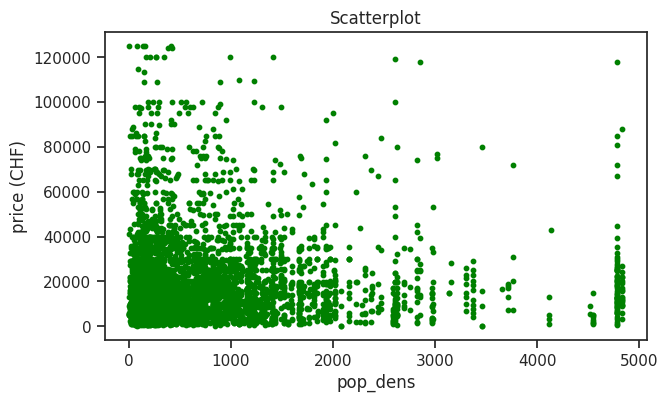

In [223]:
plt.figure(figsize=(7,4))
plt.scatter(filtered_df['pop_dens'], 
           filtered_df['price'], 
           color="green", 
           alpha=1.0,
           s=10)
plt.title('Scatterplot', fontsize=12)
plt.xlabel('pop_dens')
plt.ylabel('price (CHF)')
plt.show()


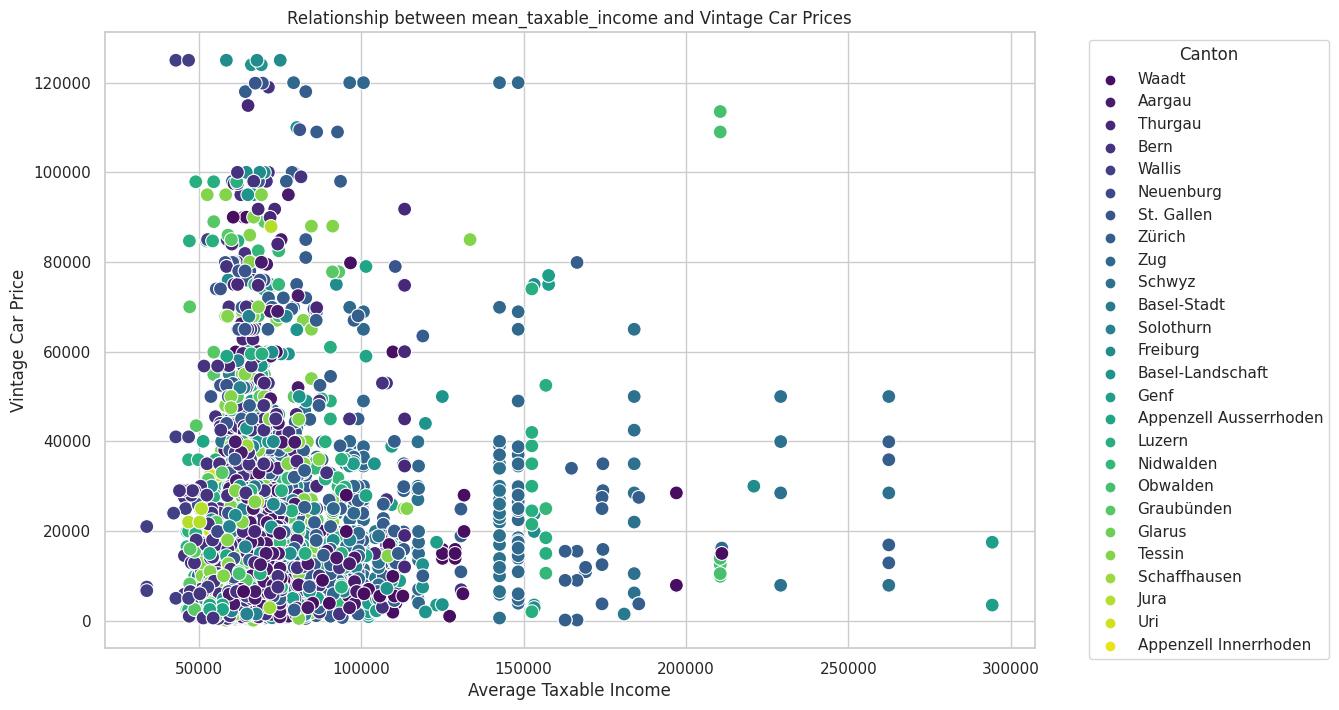

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Create scatter plot
scatterplot = sns.scatterplot(x='mean_taxable_income', y='price', data=filtered_df, hue='canton', palette='viridis', s=100)

# Adjust the plot
scatterplot.set_title('Relationship between mean_taxable_income and Vintage Car Prices')
scatterplot.set_xlabel('Average Taxable Income')
scatterplot.set_ylabel('Vintage Car Price')

# Add legend
plt.legend(title='Canton', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


### Close DB connection

In [221]:
conn.close()

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [222]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.2.0-1018-azure
Datetime: 2024-01-02 16:45:27
Python Version: 3.10.12
-----------------------------------
